# Multi-Dimension Regression: Grand Junction Weather Data

In [ ]:
## 1. Load GJ Weather Data:

In [3]:
# Jupyter-friendly installs (safe to re-run)
%pip install --quiet pandas numpy scikit-learn matplotlib requests pytz

import pandas as pd
import requests
from datetime import date
import pytz

# --- Grand Junction, CO approximate coordinates ---
LAT, LON = 39.0639, -108.5506

# --- Date range (edit as needed) ---
START = "2000-01-01"
END   = date.today().isoformat()

# Daily variables (pick a good spread of physics + moisture + energy)
DAILY_VARS = [
    "temperature_2m_max", "temperature_2m_min",
    "precipitation_sum", "rain_sum", "snowfall_sum",
    "windspeed_10m_max", "windgusts_10m_max",
    "shortwave_radiation_sum", "et0_fao_evapotranspiration",
    "sunshine_duration", "daylight_duration"
]
params = {
    "latitude": LAT,
    "longitude": LON,
    "start_date": START,
    "end_date": END,
    "daily": ",".join(DAILY_VARS),
    "timezone": "America/Denver"
}

url = "https://archive-api.open-meteo.com/v1/archive"
resp = requests.get(url, params=params, timeout=60)
resp.raise_for_status()
raw = resp.json()

df = pd.DataFrame(raw["daily"])
df["time"] = pd.to_datetime(df["time"])
df = df.set_index("time").sort_index()

# Make columns nicer
df.columns = [c.replace("_2m", "").replace("_10m", "") for c in df.columns]

print("Rows:", len(df))
df.head(10)



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.4.4/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Rows: 2493


,temperature_max,temperature_min,precipitation_sum,rain_sum,snowfall_sum,windspeed_max,windgusts_max,shortwave_radiation_sum,et0_fao_evapotranspiration,sunshine_duration,daylight_duration
time,,,,,,,,,,,
2019-01-01,-6.6,-13.0,1.1,0.0,0.77,7.6,18.4,6.92,0.51,24595.22,34135.01
2019-01-02,-3.8,-16.1,0.0,0.0,0.00,8.4,15.8,10.18,0.80,30557.98,34177.73
2019-01-03,-1.1,-13.3,0.0,0.0,0.00,9.7,21.6,9.68,0.86,30610.14,34224.28
2019-01-04,1.0,-8.6,0.0,0.0,0.00,6.1,19.4,9.60,0.89,30666.39,34274.55
2019-01-05,1.4,-8.7,0.0,0.0,0.00,8.6,24.8,7.07,0.81,20291.09,34328.43
2019-01-06,2.1,-4.2,5.4,0.2,3.64,14.5,31.3,3.25,0.53,6017.20,34385.80
2019-01-07,4.9,-4.1,0.5,0.0,0.35,13.0,25.9,4.05,0.70,22569.31,34446.55
2019-01-08,5.0,-5.2,0.0,0.0,0.00,6.7,19.8,9.42,1.05,30929.45,34510.57
2019-01-09,4.5,-5.0,0.0,0.0,0.00,8.9,21.6,7.98,0.96,31004.06,34577.74


## 2) Target & Feature Engineering

In [5]:
import numpy as np

data = df.copy()

# Calendar features
data["doy"]  = data.index.dayofyear
data["month"] = data.index.month

# Optional lags (helps capture persistence)
for col in ["temperature_max", "temperature_min", "precipitation_sum"]:
    if col in data.columns:
        data[f"{col}_lag1"] = data[col].shift(1)

# Drop first row due to lags
data = data.dropna()

# Define target and candidate predictors
target = "temperature_max"
predictors = [
    "temperature_min",
    "precipitation_sum", "rain_sum", "snowfall_sum",
    "windspeed_max", "windgusts_max",
    "shortwave_radiation_sum", "et0_fao_evapotranspiration",
    "sunshine_duration", "daylight_duration",
    "doy", "month",
    "temperature_max_lag1", "temperature_min_lag1", "precipitation_sum_lag1"
]
# Keep only columns that exist
predictors = [p for p in predictors if p in data.columns]

X = data[predictors].copy()
y = data[target].copy()

X.head(), y.head()


(            temperature_min  precipitation_sum  rain_sum  snowfall_sum  \
 time                                                                     
 2019-01-02            -16.1                0.0       0.0          0.00   
 2019-01-03            -13.3                0.0       0.0          0.00   
 2019-01-04             -8.6                0.0       0.0          0.00   
 2019-01-05             -8.7                0.0       0.0          0.00   
 2019-01-06             -4.2                5.4       0.2          3.64   
 
             windspeed_max  windgusts_max  shortwave_radiation_sum  \
 time                                                                
 2019-01-02            8.4           15.8                    10.18   
 2019-01-03            9.7           21.6                     9.68   
 2019-01-04            6.1           19.4                     9.60   
 2019-01-05            8.6           24.8                     7.07   
 2019-01-06           14.5           31.3            

## 3) Train/Test Split and Linear Regression

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


skewed = [c for c in ["precipitation_sum","rain_sum","snowfall_sum",
                      "shortwave_radiation_sum","et0_fao_evapotranspiration",
                      "sunshine_duration"] if c in X.columns]

X_lin = X.copy()
for c in skewed:
    X_lin[c] = np.log1p(X_lin[c])

X_used = X_lin  # ✅ This variable must exist before splitting


X_train, X_test, y_train, y_test = train_test_split(
    X_used, y, test_size=0.2, random_state=42, shuffle=True
)

lin_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

lin_pipe.fit(X_train, y_train)

y_pred_train = lin_pipe.predict(X_train)
y_pred_test  = lin_pipe.predict(X_test)

def metrics(y_true, y_pred, label=""):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{label}MSE={mse:.3f} | RMSE={rmse:.3f} | MAE={mae:.3f} | R^2={r2:.3f}")
    return dict(MSE=mse, RMSE=rmse, MAE=mae, R2=r2)

m_train = metrics(y_train, y_pred_train, label="Train  ")
m_test  = metrics(y_test,  y_pred_test,  label="Test   ")


Train  MSE=3.500 | RMSE=1.871 | MAE=1.414 | R^2=0.976
Test   MSE=4.001 | RMSE=2.000 | MAE=1.522 | R^2=0.972


## 5) Vizualization of residuals vs fitted line

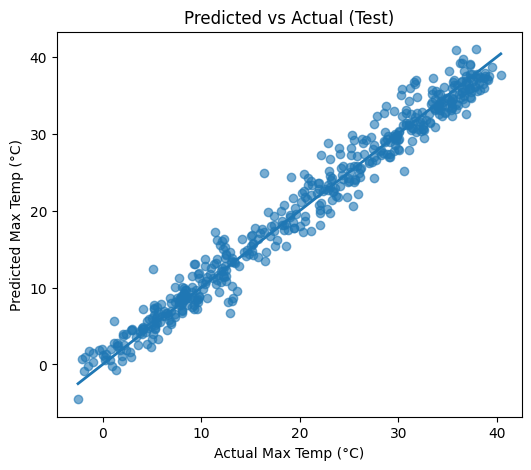

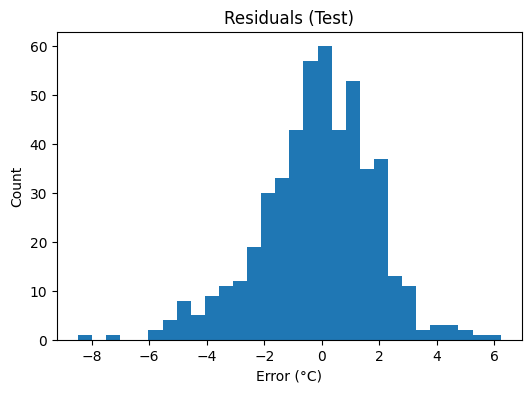

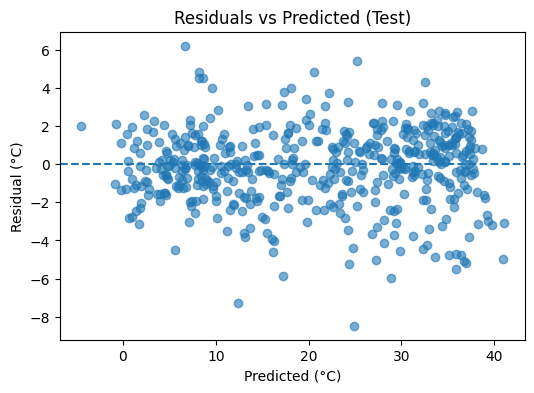

In [9]:
import matplotlib.pyplot as plt

resid = y_test - y_pred_test

# Predicted vs Actual
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.xlabel("Actual Max Temp (°C)")
plt.ylabel("Predicted Max Temp (°C)")
plt.title("Predicted vs Actual (Test)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], lw=2)
plt.show()

# Residuals histogram
plt.figure(figsize=(6,4))
plt.hist(resid, bins=30)
plt.title("Residuals (Test)")
plt.xlabel("Error (°C)")
plt.ylabel("Count")
plt.show()

# Residuals vs Predicted
plt.figure(figsize=(6,4))
plt.scatter(y_pred_test, resid, alpha=0.6)
plt.axhline(0, ls="--")
plt.xlabel("Predicted (°C)")
plt.ylabel("Residual (°C)")
plt.title("Residuals vs Predicted (Test)")
plt.show()


## 6) 2D Slices

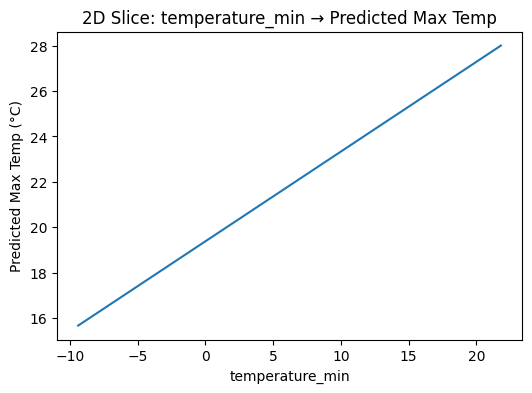

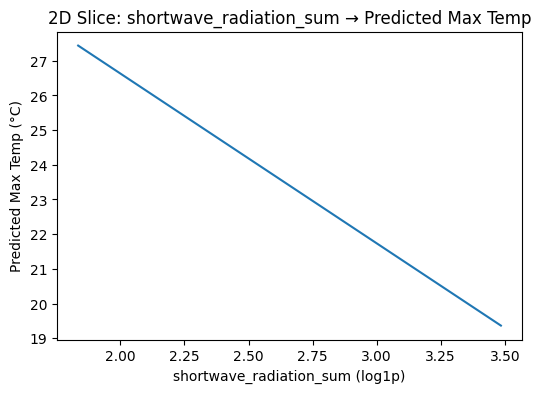

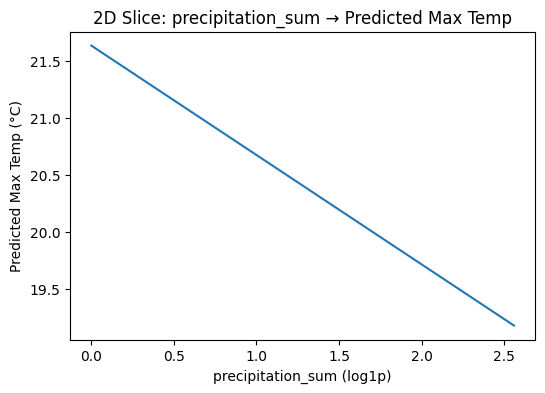

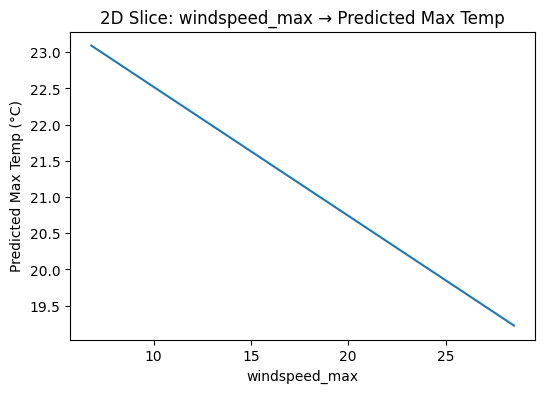

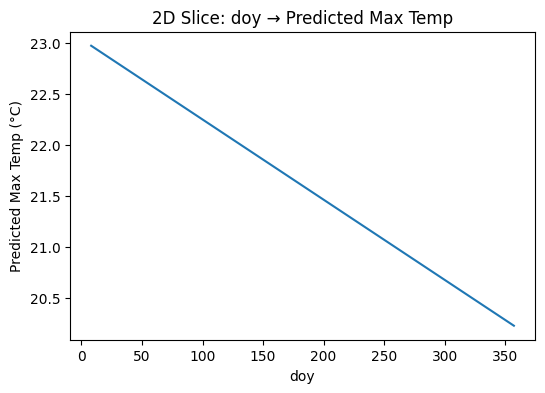

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_1d_slice(feature, grid_pts=50):
    if feature not in X_used.columns:
        print(f"{feature} not in features")
        return

    # Baseline row at medians
    median_row = X_used.median().to_frame().T

    # Grid over the chosen feature
    fmin, fmax = X_used[feature].quantile([0.02, 0.98])  # robust range
    grid = np.linspace(fmin, fmax, grid_pts)

    preds = []
    for val in grid:
        row = median_row.copy()
        row[feature] = val
        preds.append(lin_pipe.predict(row)[0])

    plt.figure(figsize=(6,4))
    plt.plot(grid, preds)
    plt.xlabel(feature + (" (log1p)" if feature in skewed else ""))
    plt.ylabel("Predicted Max Temp (°C)")
    plt.title(f"2D Slice: {feature} → Predicted Max Temp")
    plt.show()

# Try a few influential features:
for f in ["temperature_min", "shortwave_radiation_sum", "precipitation_sum", "windspeed_max", "doy"]:
    if f in X_used.columns:
        plot_1d_slice(f)


In [11]:
## 7) Standardized Coefficients

In [12]:
import numpy as np
import pandas as pd

# Extract standardized coefficients (since we used a StandardScaler)
coefs = lin_pipe.named_steps["linreg"].coef_
feat_names = X_used.columns

coef_df = pd.DataFrame({
    "feature": feat_names,
    "std_coef": coefs
}).sort_values("std_coef", key=np.abs, ascending=False)

coef_df.head(15)


,feature,std_coef
7,et0_fao_evapotranspiration,9.492453
0,temperature_min,3.742593
12,temperature_max_lag1,2.757223
6,shortwave_radiation_sum,-2.231009
9,daylight_duration,-1.194360
11,month,0.987082
4,windspeed_max,-0.985525
10,doy,-0.821707
1,precipitation_sum,-0.643953
2,rain_sum,0.543203
